In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
path = '/home/jovyan/'
from matplotlib import rcParams
import seaborn as sns
# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Loading data and metadata

In [64]:
# Let's load the data and metadata from our Nanostring experiment:

counts = pd.read_table(path + 'KR_NAS/Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
subset_genes = np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288
counts = counts[subset_genes]
metadata = pd.read_csv(path + 'KR_NAS/NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table(path + 'KR_NAS/Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))]
negProbes = pd.read_csv(path + 'KR_NAS/Sanger_dedup_withNegProbes.csv')
negProbes = negProbes.loc[negProbes.iloc[:,0] == 'NegProbe-WTX',]
genes = negProbes['Unnamed: 0']
negProbes = negProbes.drop('Unnamed: 0',1)
negProbes = negProbes.rename(index=genes)
negProbes = negProbes.astype('int')
negProbes = negProbes[counts.keys()]
polioudakis = pd.read_csv('/home/jovyan/data/fetalBrain/Polioudakis/cellStateMatrix.csv')
genes = polioudakis.iloc[:,0]
polioudakis = polioudakis.drop('Unnamed: 0',1)
polioudakis = polioudakis.rename(index=genes)

# Choose which ROIs and genes to use, e.g. top 100 markers of each cell type:
rSlides = ('00MU', '00MV', '00MV-2')
markers = pd.read_csv('/home/jovyan/data/fetalBrain/Polioudakis/clusterMarkers.csv')

N = 100
columnNames = np.unique(markers['cluster'])
topN_markers = pd.DataFrame(index=range(N), columns=columnNames)
for i in range(len(columnNames)):
    topN_temp = np.array(markers[markers['cluster'] == columnNames[i]].iloc[0:N,].iloc[:,0])
    topN_markers[columnNames[i]] = [topN_temp[i].split('.')[0] for i in range(len(topN_temp))]
genes_new = np.array(topN_markers).flatten()  

subset = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')
                            for i in range(len(metadata['slide']))])[0]

Y_data = np.array(negProbes.iloc[:,subset]).T
counts_subset = counts.iloc[:,subset]
subset_genes = [counts_subset.index[i] in genes_new for i in range(len(counts_subset.index))]
counts_subset = counts_subset.iloc[subset_genes,:]
cellstateMatrix = polioudakis.reindex(np.array(counts_subset.index))
n_nuclei = np.array(properties['nuclei'])[subset]

Plot the mean negative counts as a function of various covariates, suggests total gene counts as the most important one:

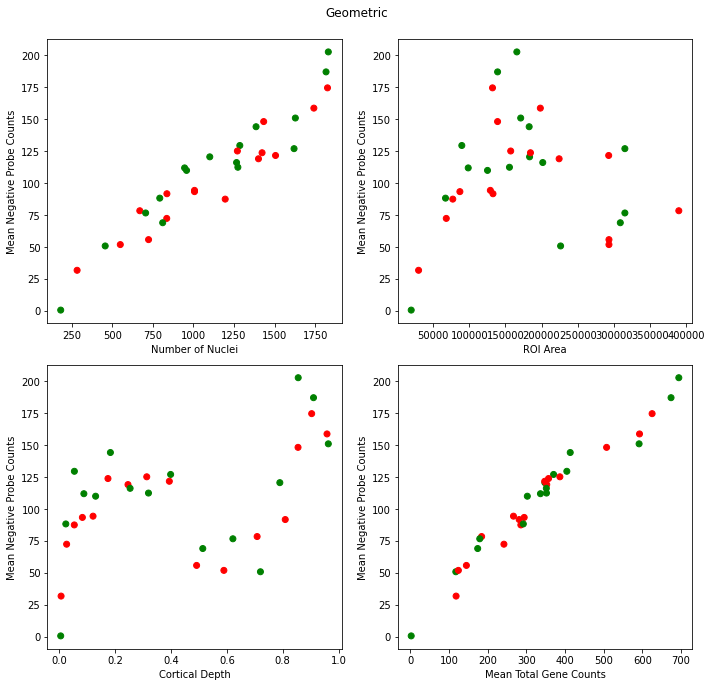

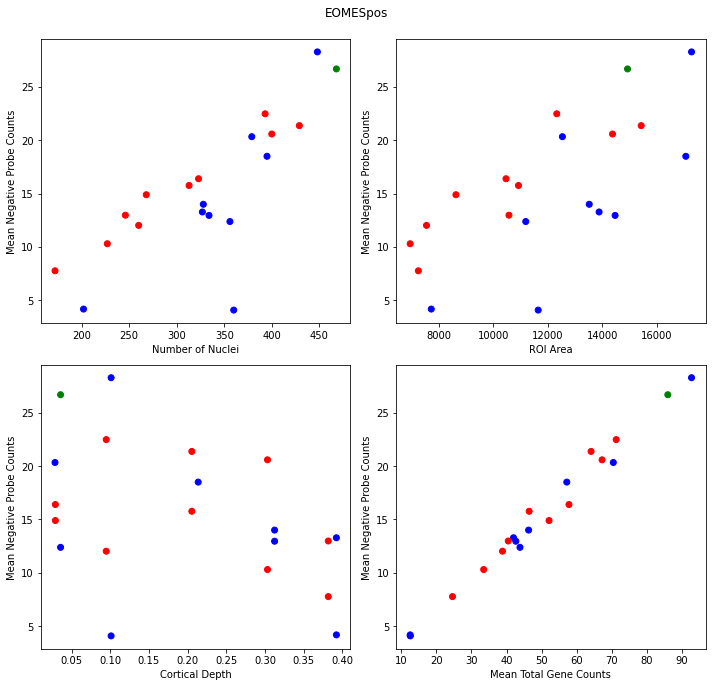

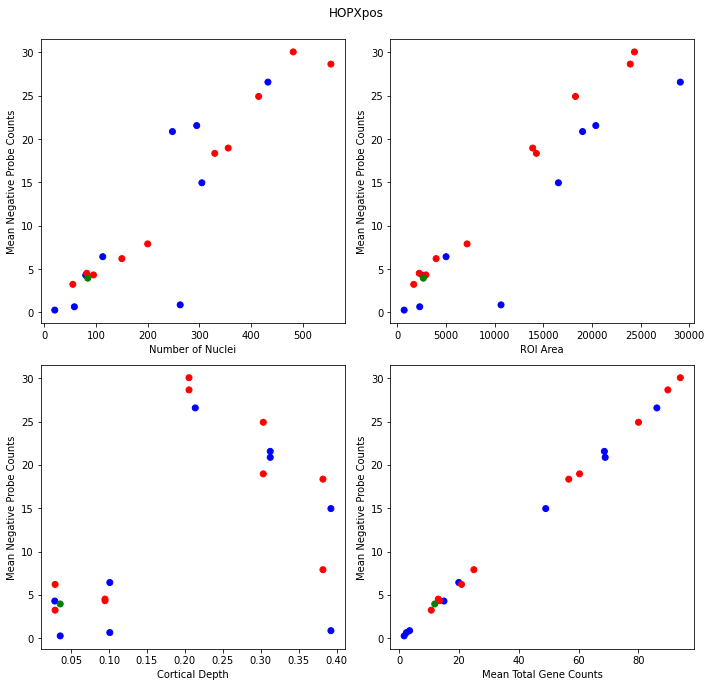

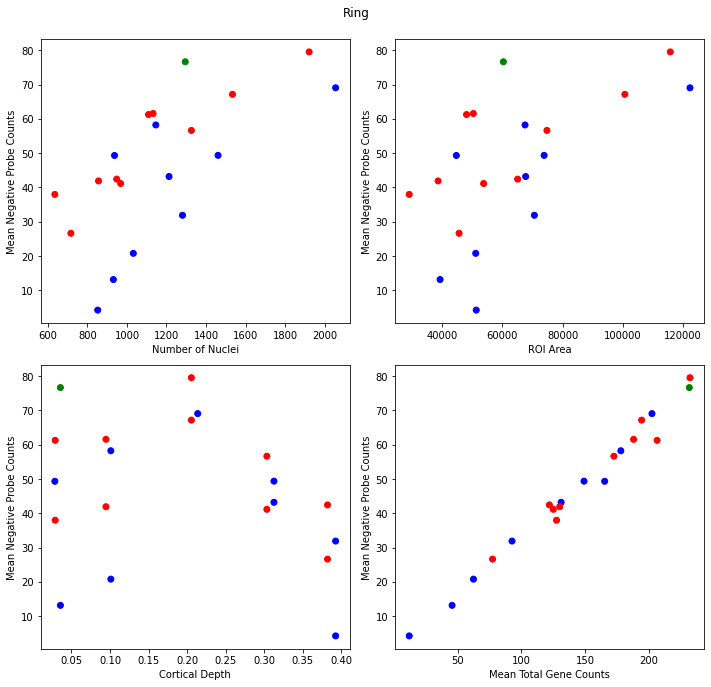

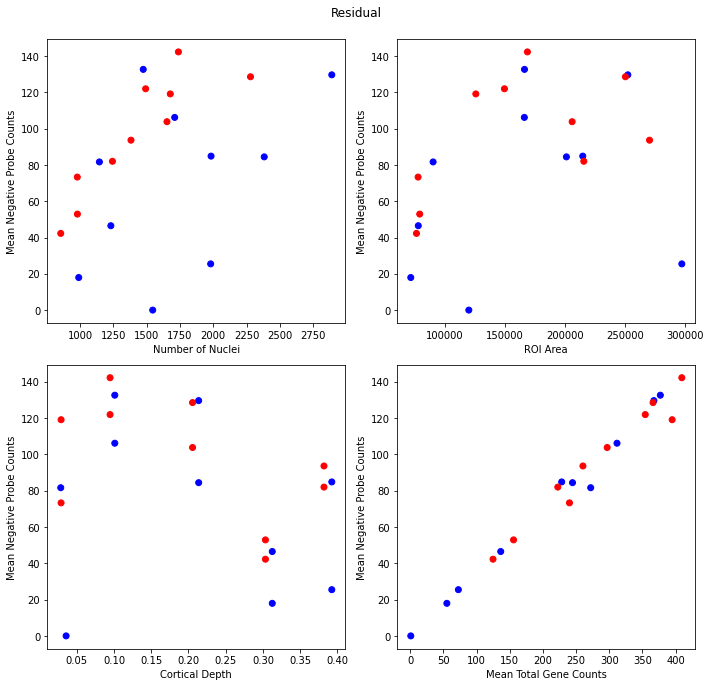

In [4]:
# Let's look at the background counts in our different types of 19pcw ROIs/AOIs:

rSlides = ('00MU', '00MV', '00MV-2')
subsets = []
types = ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')

subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] == 2
                   and metadata['AOI_type'][i] == types[0] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[1] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[2] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[3] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[4] for i in range(len(metadata['slide']))]))

for x in range(5):
    geneTotal = np.array([np.mean(counts.iloc[:,i]) for i in subsets[x]])
    negTotal = np.array([np.mean(negProbes.iloc[:,i]) for i in subsets[x]])
    numNuclei = np.array(properties['nuclei'])[subsets[x]]
    roiDim = np.array(properties['roi_dimension'])[subsets[x]]
    vcDepth = np.array(metadata['VCDepth'])[subsets[x]]
    slide = np.array(metadata['slide'])[subsets[x]]
    pcw = np.array(metadata['age'])[subsets[x]]
    
    colour = np.repeat('green', len(subsets[x][0]))
    colour[slide == '00MU'] = 'red'
    colour[slide == '00MV-2'] = 'blue'
    
    fig, ax = plt.subplots(2, 2, figsize = (10,10))
    ax[0,0].scatter(numNuclei, negTotal, c = colour)
    ax[0,0].set_ylabel('Mean Negative Probe Counts')
    ax[0,0].set_xlabel('Number of Nuclei')
    ax[0,1].scatter(roiDim, negTotal, c = colour)
    ax[0,1].set_ylabel('Mean Negative Probe Counts')
    ax[0,1].set_xlabel('ROI Area')
    ax[1,0].scatter(vcDepth, negTotal, c = colour)
    ax[1,0].set_ylabel('Mean Negative Probe Counts')
    ax[1,0].set_xlabel('Cortical Depth')
    ax[1,1].scatter(geneTotal, negTotal, c = colour)
    ax[1,1].set_ylabel('Mean Negative Probe Counts')
    ax[1,1].set_xlabel('Mean Total Gene Counts')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(types[x])
    fig.savefig(types[x] + '.pdf')


Check if some negative probes have consistently higher counts than others:

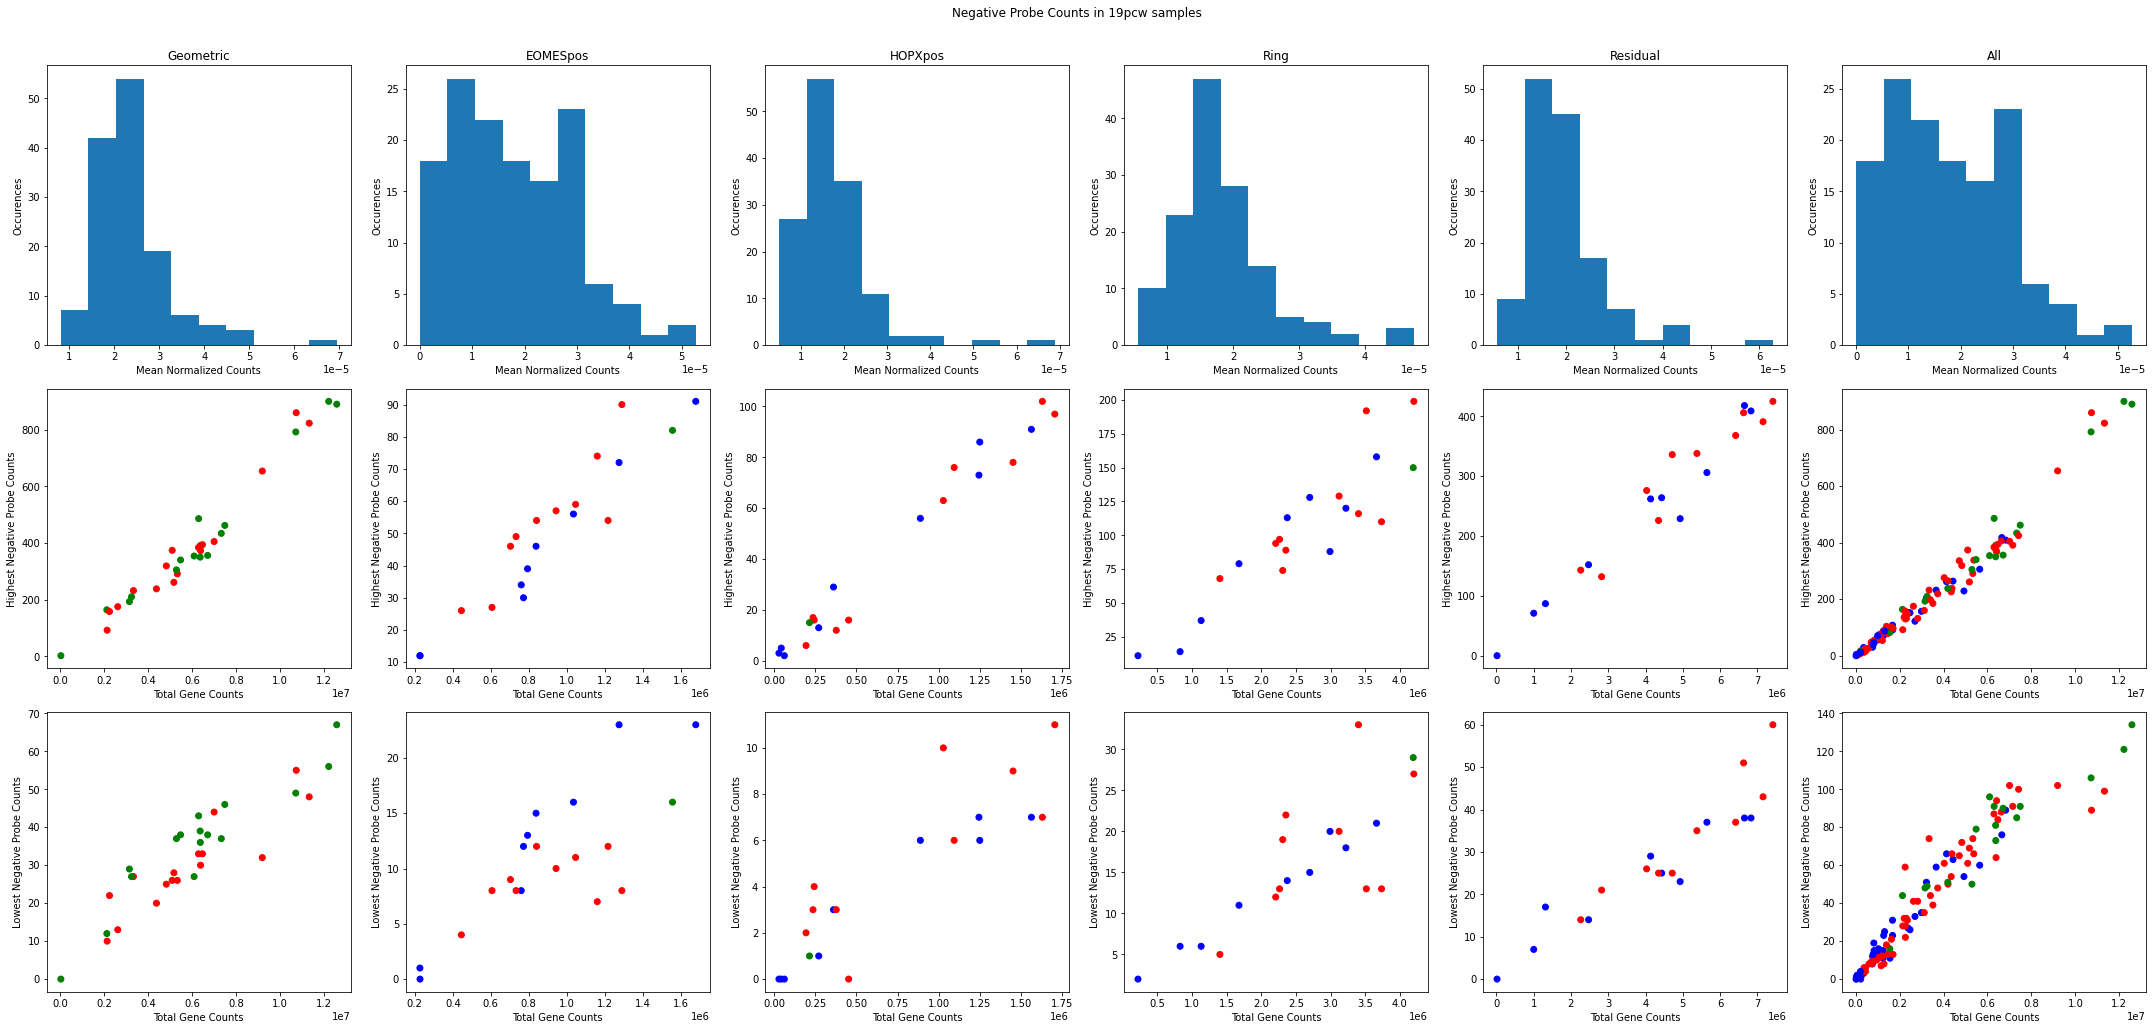

In [5]:
rSlides = ('00MU', '00MV', '00MV-2')
subsets = []
types = ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual', 'All')

subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] == 2
                   and metadata['AOI_type'][i] == types[0] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[1] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[2] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[3] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3)
                   and metadata['AOI_type'][i] == types[4] for i in range(len(metadata['slide']))]))
subsets.append(np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in types for i in range(len(metadata['slide']))]))

fig, ax = plt.subplots(3, 6, figsize = (30,15))
for x in range(6):
    geneTotal = np.array([np.sum(counts.iloc[:,i]) for i in subsets[x]])[0]
    negMean = np.array([np.mean(negProbes.iloc[:,i]) for i in subsets[x]])[0]
    normCounts = np.array([np.array(negProbes.iloc[:,subsets[x][0][i]]/geneTotal[i]) for i in range(len(negTotal))])
    normMean = [np.mean(normCounts[:,i]) for i in range(np.shape(normCounts)[1])]
    
    top = np.argmax(normMean)
    bottom = np.argmin(normMean)


    negTop = np.array([negProbes.iloc[top,i] for i in subsets[x]])[0]
    negBottom = np.array([negProbes.iloc[bottom,i] for i in subsets[x]])[0]

    slide = np.array(metadata['slide'])[subsets[x]]

    colour = np.repeat('green', len(subsets[x][0]))
    colour[slide == '00MU'] = 'red'
    colour[slide == '00MV-2'] = 'blue'

    ax[0,x].hist(normMean)
    ax[0,x].set_xlabel('Mean Normalized Counts')
    ax[0,x].set_ylabel('Occurences')
    ax[0,x].set_title(types[x])
    ax[1,x].scatter(geneTotal, negTop, c = colour)
    ax[1,x].set_ylabel('Highest Negative Probe Counts')
    ax[1,x].set_xlabel('Total Gene Counts')
    ax[2,x].scatter(geneTotal, negBottom, c = colour)
    ax[2,x].set_ylabel('Lowest Negative Probe Counts')
    ax[2,x].set_xlabel('Total Gene Counts')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Negative Probe Counts in 19pcw samples')
    fig.savefig(types[x] + '.pdf')



Based on this make a generative model of probe counts:

In [65]:
# -*- coding: utf-8 -*-
"""Default Generative Model for GeoMx counts"""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

from pycell2location.models.pymc3_model import Pymc3Model 

# defining the model itself
class GeoMxCounts(Pymc3Model):
    r"""GeoMx background noise model
    :param X_data: Numpy array of negative probe counts (cols) in ROIs (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    """

    def __init__(
        self,
        X_data: np.ndarray,
        Y_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 200000,
        learning_rate = 0.001,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        n_components = 20,
        cutoff_poisson = 1000
    ):
        
        ############# Initialise parameters ################
        super().__init__(X_data, 0,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose)
        self.Y_data = Y_data
        self.y_data = theano.shared(Y_data.astype(self.data_type))
        self.n_rois = Y_data.shape[0]
        self.l_r = np.array([np.sum(X_data[i,:]) for i in range(self.n_rois)]).reshape(self.n_rois,1)
        self.n_components = n_components
        self.n_npro = Y_data.shape[1]
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        self.X_data1 = self.X_data[self.poisson_residual]
        self.X_data2 = self.X_data[self.gamma_residual]
        self.genes = var_names
        self.sample_names = obs_names
        
        ############# Define the model ################
        self.model = pm.Model()
        with self.model:
            
            ### Negative Probe Counts ###
            
            # Prior for distribution of negative probe count levels:
            self.b_n_hyper = pm.Gamma('b_n_hyper', mu = 3*10**(-5), sigma = 1*10**(-5), shape = 2)
            # The distribution of negative probe count levels:
            self.b_n = pm.Gamma('b_n', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_npro))
            # The expected mean of each negative probe based on its count level and total counts in this roi:
            self.y_nr = self.b_n*self.l_r
            
            ### Gene Counts ###
            
            # Background for gene probes, drawn from the same distribution as negative probes:
            self.b_g = pm.Gamma('b_g', mu = self.b_n_hyper[0], sigma = self.b_n_hyper[1], shape = (1,self.n_genes))

            # Gene expression modeled as combination of non-negative components:
            self.h = pm.Dirichlet('h', a=np.ones(self.n_genes), shape=(self.n_components, self.n_genes))
            self.w_hyp = pm.Gamma('w_hyp', np.array((1,1)), np.array((0.1,0.01)), shape=(self.n_components,2))
            self.w = pm.Gamma('w', mu=self.w_hyp[:,0], sigma=self.w_hyp[:,1], shape=(self.n_rois, self.n_components))
            self.a_gr =  pm.Deterministic('a_gr', pm.math.dot(self.w, self.h))
            
            # Expected gene counts are sum of gene expression and background counts, scaled by library size:
            self.x_rg = (self.a_gr + self.b_g)*self.l_r
            
            # Poisson sampling of negative probes:
            self.data_target1 = pm.Poisson('data_target0', mu=self.y_nr,
                                          observed=self.y_data,
                                          total_size=self.Y_data.shape)
            
            # Poisson sampling of gene probes with counts less than poisson_cutoff... 
            self.data_target2 = pm.Poisson('data_target1', mu=self.x_rg[self.poisson_residual],
                                          observed=self.x_data[self.poisson_residual],
                                          total_size=self.X_data1.shape)
            
            # ... and Gamma for gene probes with counts more than poisson_cutoff
            self.data_target3 = pm.Gamma('data_target2', mu=self.x_rg[self.gamma_residual],
                                          sd = np.sqrt(self.x_rg[self.gamma_residual]),
                                          observed=self.x_data[self.gamma_residual],
                                          total_size=self.X_data2.shape)
               
    def plot_prior_vs_data(self, data_target_name=('data_target0', 'data_target1', 'data_target2'),
                           data_node=('Y_data', 'X_data1', 'X_data2')):
        r""" Plot data vs a single sample from the prior in a 2D histogram
        Uses self.X_data and self.prior_trace['data_target'].
        :param data_node: name of the object slot containing data
        """
        
        if len(data_node) == 1:
            data_node = getattr(self, data_node)
            plt.hist2d(np.log10(data_node.flatten()+1),
            np.log10(self.prior_trace[data_target_name].flatten()+1),
            bins = 50, norm=matplotlib.colors.LogNorm())
            plt.xlabel('Data, log10(nUMI)')
            plt.ylabel('Prior sample, log10(nUMI)')
            plt.title('UMI counts (all spots, all genes)')
            plt.tight_layout()
        else:
            data_node_list = []
            for i in range(len(data_node)):
                data_node_list.append(getattr(self, data_node[i]))
            fig, ax = plt.subplots(1, 3, figsize = (30,10))
            for i in range(len(data_node_list)):
                ax[i].hist2d(np.log10(data_node_list[i].flatten()+1),
                np.log10(self.prior_trace[data_target_name[i]].flatten()+1),
                bins = 50, norm=matplotlib.colors.LogNorm())
                ax[i].set_xlabel('Data, log10(nUMI)', fontsize=25)
                ax[i].set_ylabel('Prior sample, log10(nUMI)', fontsize=25)
                ax[i].set_title(data_target_name[i] + ': UMI counts (all spots, all genes)', fontsize=25)
                ax[i].tick_params(axis='both', which='major', labelsize=25)
                ax[i].tick_params(axis='both', which='minor', labelsize=25)

            plt.tight_layout()
    
    def compute_expected(self):
        r""" Save expected value of negative probe poisson mean and negative probe level"""
        # compute expected mean of negative probes:
        self.y_nr_mean = self.samples['post_sample_means']['b_n'] * self.l_r
        # compute expected mean of normalized gene probe counts:
        self.a_gr_mean = self.samples['post_sample_means']['a_gr']
        # compute expected mean of unnormalized gene probe counts:
        self.x_rg_mean = (self.a_gr_mean + self.samples['post_sample_means']['b_g'])*self.l_r
        
    def compute_logFC(self, groupA = 3, groupB = 6, n_samples = 1000):
        r"""Compute log-fold change of genes between two ROIs or two groups of ROIs, as well as associated
        standard deviation and 0.05 and 0.95 percentile"""
        post_sample_a_gr = self.mean_field['init_1'].sample_node(self.a_gr, size = n_samples).eval()
        self.logFC = pd.DataFrame(index = self.genes, columns = ('groupA', 'groupB', 'mean', 'sd', 'q05', 'q95'))
        self.logFC['groupA'] = self.sample_names[groupA]
        self.logFC['groupB'] = self.sample_names[groupB]
        self.logFC_sample = np.log2(post_sample_a_gr[:,groupA,:]) - np.log2(post_sample_a_gr[:,groupB,:])
        self.logFC['mean'] = self.logFC_sample.mean(axis=0)
        self.logFC['sd'] = self.logFC_sample.std(axis=0)
        self.logFC['q05'] = np.quantile(self.logFC_sample, 0.05, axis=0)
        self.logFC['q95'] = np.quantile(self.logFC_sample, 0.95, axis=0)  
        
    def compute_FDR(self, logFC_threshold = 1):
        r"""Compute probability that logFC is above a certain threshold 
        and also include FDR for each probability level."""
        self.logFC['threshold'] = logFC_threshold
        self.logFC['probability'] = np.sum(np.abs(self.logFC_sample) > logFC_threshold, axis = 0)/np.shape(self.logFC_sample)[0]
        prob_unique = -np.sort(-np.unique(self.logFC['probability']))
        FDR_unique = np.array([sum(1-prob_unique[:i+1])/(i+1) for i in range(len(prob_unique))])
        self.logFC['FDR'] = np.array([FDR_unique[np.where(prob_unique == self.logFC['probability'][i])][0] for i in range(len(self.logFC['probability']))])
        self.logFC = self.logFC.sort_values('FDR')
        

Run model on good ROIs in 19pcw sample:

In [66]:
rSlides = ('00MU', '00MV', '00MV-2')

subset = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')
                            for i in range(len(metadata['slide']))])[0]

X_data = np.array(counts_subset).T
Y_data = np.array(negProbes.iloc[:,subset]).T

In [48]:
metadata_subset = metadata.iloc[subset,:]
np.where(metadata_subset['AOI_type'] == 'EOMESpos')
np.where(metadata_subset['AOI_type'] == 'HOPXpos')

(array([  5,   6,  13,  14,  21,  22,  23,  42,  43,  44,  65,  66,  67,
         90,  91,  92,  93,  95, 106, 109]),)

In [68]:
mod1 = GeoMxCounts(
        X_data, Y_data,
        data_type='float32', n_iter=25000,
        learning_rate=0.001,
        total_grad_norm_constraint=200,
        verbose=False, var_names= np.array(counts_subset.index), obs_names=np.array(counts_subset.keys()))

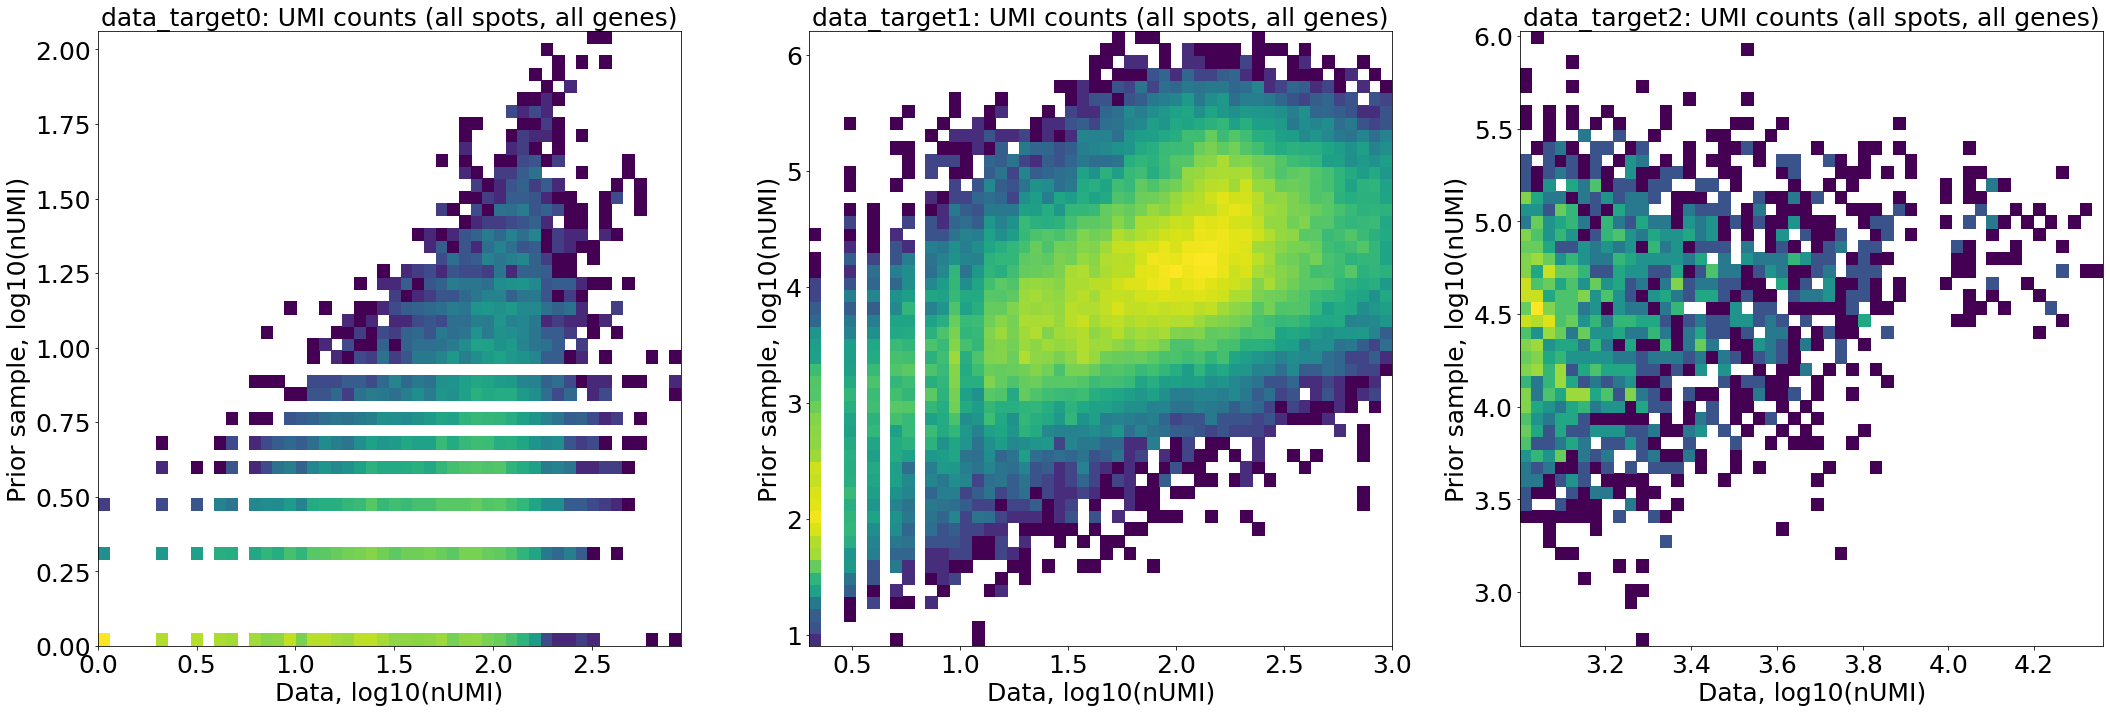

In [51]:
mod1.sample_prior()
mod1.plot_prior_vs_data()

In [69]:
mod1.fit_advi(n=1, method='advi')

Average Loss = 5.6324e+05: 100%|██████████| 25000/25000 [19:47<00:00, 21.06it/s]
Finished [100%]: Average Loss = 5.6318e+05


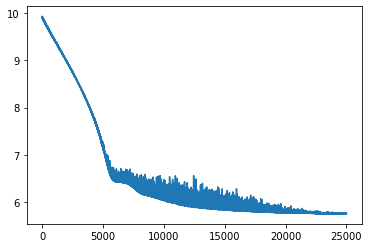

In [70]:
# mod1.plot_history()
iter_start = 0
iter_end = -1
for i in mod1.mean_field.keys():
    print(plt.plot(np.log10(mod1.mean_field[i].hist[iter_start:iter_end])));


# plt.show()
# mod1.plot_history(20000)
#mod1.mean_field['init_1'].hist

In [71]:
mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);

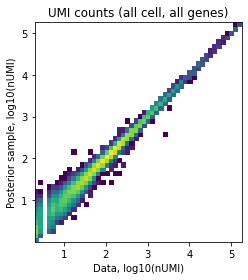

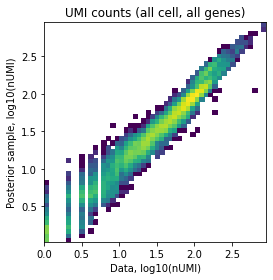

In [72]:
mod1.compute_expected()
mod1.plot_posterior_mu_vs_data(mu_node_name='x_rg_mean', data_node='X_data')
plt.show()
mod1.plot_posterior_mu_vs_data(mu_node_name='y_nr_mean', data_node='Y_data')

In [73]:
mod1.compute_logFC(groupA = 3, groupB = 6, n_samples = 1000)
mod1.compute_FDR(logFC_threshold = 1)

In [74]:
mod1.logFC.sort_values('FDR')

,groupA,groupB,mean,sd,q05,q95,threshold,probability,FDR
EOMES,HCA_F_BRA8739095,HCA_F_BRA8739104,1.590819,0.078034,1.461891,1.719566,1,1.0,0.000000
TAGLN2,HCA_F_BRA8739095,HCA_F_BRA8739104,-1.319227,0.050299,-1.402790,-1.238834,1,1.0,0.000000
HES1,HCA_F_BRA8739095,HCA_F_BRA8739104,-1.734327,0.083708,-1.868094,-1.595077,1,1.0,0.000000
HES5,HCA_F_BRA8739095,HCA_F_BRA8739104,-1.442046,0.102242,-1.606732,-1.271612,1,1.0,0.000000
HES6,HCA_F_BRA8739095,HCA_F_BRA8739104,1.994872,0.091690,1.843071,2.139852,1,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
SULT1E1,HCA_F_BRA8739095,HCA_F_BRA8739104,-0.130303,0.147831,-0.361015,0.108877,1,0.0,0.566592
PRR11,HCA_F_BRA8739095,HCA_F_BRA8739104,0.616356,0.075856,0.494877,0.740229,1,0.0,0.566592
PRRX1,HCA_F_BRA8739095,HCA_F_BRA8739104,-0.267894,0.100741,-0.427840,-0.097114,1,0.0,0.566592
SLITRK5,HCA_F_BRA8739095,HCA_F_BRA8739104,-0.005057,0.126307,-0.215925,0.204515,1,0.0,0.566592


In [75]:
sum(mod1.logFC['FDR'] < 0.05)

99

In [79]:
mod1.logFC.index[mod1.logFC['FDR'] < 0.05]

Index(['EOMES', 'SPP1', 'PDZRN3', 'TMEM158', 'ERBB4', 'SPARC', 'TOP2A',
       'GADD45G', 'BCAN', 'IVNS1ABP', 'SOX9', 'CLMP', 'EPHA3', 'RRM2',
       'ATP1B2', 'ENC1', 'ATP1A2', 'CLU', 'PEA15', 'PENK', 'FN1', 'ID4',
       'GATM', 'GFAP', 'PSAT1', 'ST8SIA5', 'CDO1', 'PPP1R17', 'GPX3', 'FZD8',
       'CNN3', 'FSTL1', 'TAGLN2', 'HES1', 'HES5', 'HES6', 'PLS3', 'CALB2',
       'FOS', 'CACNA2D1', 'POU3F2', 'ARX', 'GAD1', 'LOX', 'LIPG', 'WWTR1',
       'CRYAB', 'VIM', 'WLS', 'SETD7', 'DDAH1', 'NEUROD4', 'SMOC1', 'ZFP36L1',
       'MKI67', 'MLLT3', 'DLX2', 'DLX5', 'SFRP2', 'NEUROD6', 'ITGB8', 'ITM2A',
       'IGFBP7', 'UNC5D', 'SLA', 'CENPF', 'PROX1', 'SLC6A1', 'NEUROD1', 'SOX1',
       'NEUROD2', 'SATB2', 'CDKN2C', 'SOX3', 'LRP8', 'FGFBP3', 'BHLHE22',
       'SLAIN1', 'CCND2', 'PTPRK', 'PLXNA4', 'QKI', 'ELAVL2', 'ANXA2', 'THBS1',
       'ADRA2A', 'NRXN3', 'ZEB2', 'SPC25', 'ZBTB18', 'SERPINE2', 'PRC1',
       'SLC7A5', 'THRB', 'JUN', 'NCAPG', 'INA', 'DLGAP5', 'NOTCH3'],
      dtype='object')